# Optimizing your video conference background with RoomRater

In [1]:
import pandas as pd
import numpy as np
import json
import os
import io
from io import BytesIO

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import tweepy
from tweepy import Cursor

import re 

import requests
from PIL import Image
from matplotlib.pyplot import imshow

import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score

random_state = 5

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\laure\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laure\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\laure\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\laure\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
import sys
print(sys.version)

3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]


## Data Collection

Skip to the **Loading Data** selection to begin with the stored tweets.

In [7]:
consumer_key = consumer_key
consumer_secret = consumer_secret
access_token = access_token
access_secret = access_secret

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [8]:
# Collect tweets from @ratemyskyperoom 

def get_tweets(num_tweets):
    """Input the desired number of tweets to retrieve and return a dataframe of tweets from RoomRater."""
    max_tweets = num_tweets
    
    tweet_count = 0
    errors = 0
    max_seq_errors = 2000

    tweets = []

    for status in Cursor(api.user_timeline, 
                         id='ratemyskyperoom', 
                         screen_name='Room Rater',
                         exclude_replies=True).items():

        if tweet_count == max_tweets:
            break

        if errors == max_seq_errors:
            break
        
        # Include the media url for visual analysis of backgrounds
        try: 
            tweet_id = status.id
            tweet_text = status.text
            image_url = status.entities.get('media')[0]['media_url']
            favorites = status.favorite_count

            tweet = {'tweet_id':tweet_id,
                     'tweet_text':tweet_text,
                     'image_url':image_url,
                    'favorites':favorites}

            tweets.append(tweet)

        except:
            errors += 1
            continue

        tweet_count += 1
        errors = 0

    # Store as dataframe
    tweet_df = pd.DataFrame(tweets,
                           columns = ['tweet_id',
                                      'tweet_text',
                                      'image_url',
                                      'favorites'])

    return tweet_df

#Ref: https://miguelmalvarez.com/2015/03/03/download-the-pictures-from-a-twitter-feed-using-python/

In [ ]:
# Collect a batch of tweets
tweet_df = get_tweets(2000)

# Store for easy access 
tweet_df.to_csv('roomratertweets.csv', index=False)

In [9]:
# Collect and store more tweets after some time
tweet_df2 = get_tweets(2000)
tweet_df2.to_csv('roomratertweets2.csv', index=False)

## Loading Data

In [2]:
def load_data(tweet_filepath):
    """Input filepath for stored tweets and return dataframe"""
    df = pd.read_csv(tweet_filepath)
    
    return df

In [3]:
# Load tweets
df1 = load_data('roomratertweets.csv')
df2 = load_data('roomratertweets2.csv')

In [4]:
# Append and remove duplicates (if any)
df = df1.append(df2)
print(df1.shape[0], df2.shape[0], df.shape[0])

1058 1428 2486


In [5]:
# Overlap is unlikely if the samples are far enough apart in time; however, as a precaution we should drop duplicates
df = df.drop_duplicates()

## Data Preprocessing I

First we need to extract the predictor variable, the rating, from the tweet text. Then we need to filter out any tweets RoomRater made that don't include ratings. 

We'll then explore and visualize the data before continuing with addtional preprocessing needed to prepare the data for the machine learning model.

In [6]:
# Select records with rating
def clean_data(df):
    """Input raw tweet dataframe and return filtered dataframe with tweet rating."""
    df = df.copy()
    
    rated = df[df['tweet_text'].str.contains('/10')].copy()

    # Identify the rating as the integer preceeding /10. Extract the rating and store in it's own column.
    rated['rating'] = rated['tweet_text'].str.split('/10').str[0].str.split(' ').str[-1]

    rated['rating'] = rated['rating'].str.extract('(\d+)', expand=False)

    # Remove tweets from the dataframe that do not have ratings.
    rated_clean = rated[~rated['rating'].isnull()].copy()

    rated_clean['rating'] = rated_clean['rating'].astype(int)
    
    return rated_clean

In [7]:
rated_clean = clean_data(df)

## Data Exploration and Visualization

Let's take a look at the distribution of ratings.

In [8]:
rated_clean[['tweet_id','rating']].groupby('rating').count()

,tweet_id
rating,
0,48
1,5
2,20
3,31
4,33
5,20
6,88
7,227
8,465


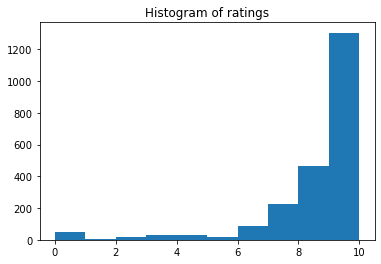

In [9]:
plt.hist(rated_clean['rating'])
plt.title('Histogram of ratings')
plt.show()

We can see the data are imbalanced toward ratings of 10/10. We will need to take this into account when choosing models and parameters.

Let's take a look at one other feature in our dataset, *favorites* (number of times a tweet was liked).

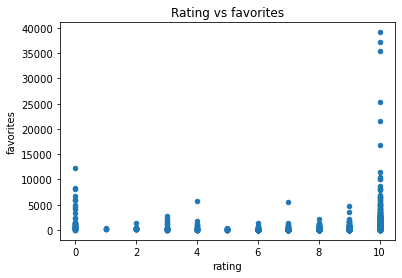

In [107]:
rated_clean.plot.scatter(x='rating',y='favorites')
plt.title('Rating vs favorites')
plt.show()

In [12]:
round(rated_clean[['rating','favorites']].corr(),3)

,rating,favorites
rating,1.000,0.052
favorites,0.052,1.000


In [10]:
round(rated_clean[['rating','favorites']].groupby('rating').mean(),1)

,favorites
rating,
0,1926.3
1,203.2
2,290.0
3,531.8
4,484.6
5,133.8
6,148.9
7,159.1
8,175.5


We can see there isn't a strong correlation between rating and favorites. Tweets rated 0/10 are the most popular, and tweets on the oposite end of the scale, 10/10 are second most popular. Favorites also don't have a linear relationship with ratings 1-9. Therefore we'll focus on the tweet text as the input for the model.

To get a feel for RoomRater data, let's create a function to view the tweet image, text, and rating.

In [8]:
def view_tweet(df, tweet_id):
    """Input tweet id and receive image and caption associated with tweet"""
    
    # Extract image url and tweet text from tweet
    image_url = df.loc[df['tweet_id'] == tweet_id, 'image_url'].iloc[0]
    text = df.loc[df['tweet_id'] == tweet_id, 'tweet_text'].iloc[0]
    
    # Retrieve image from web and plot with tweet text
    view_img = Image.open(requests.get(image_url, stream=True).raw)

    fig, ax = plt.subplots()
    plt.title('RoomRater Review')
    fig.text(.5,.07, text, ha='center', fontsize=9)
    plt.imshow(view_img)
    ax.set_axis_off()
    plt.axis('off')
    
    return plt.show()

# References:
# https://stackoverflow.com/questions/7391945/how-do-i-read-image-data-from-a-url-in-python
# https://stackoverflow.com/questions/36684013/extract-column-value-based-on-another-column-pandas-dataframe

Let's look at sample images from key rating quantiles, based on descriptive statistics.

In [15]:
round(rated_clean.describe()['rating'],1)

count    2241.0
mean        8.3
std         2.1
min         0.0
25%         8.0
50%         9.0
75%        10.0
max        10.0
Name: rating, dtype: float64

In [102]:
# Store the min, median, and max ratings
min_rating = rated_clean.rating.quantile(0)
q1_rating = rated_clean.rating.quantile(.25)
q2_rating = rated_clean.rating.quantile(.5)
max_rating = rated_clean.rating.quantile(1)

In [103]:
# Select a sample tweet for each quantile 
min_ex = rated_clean.query('rating == @min_rating').iloc[1][0]
q1_ex = rated_clean.query('rating == @q1_rating').iloc[0][0]
q2_ex = rated_clean.query('rating == @q2_rating').iloc[0][0]
max_ex = rated_clean.query('rating == @max_rating').iloc[0][0]

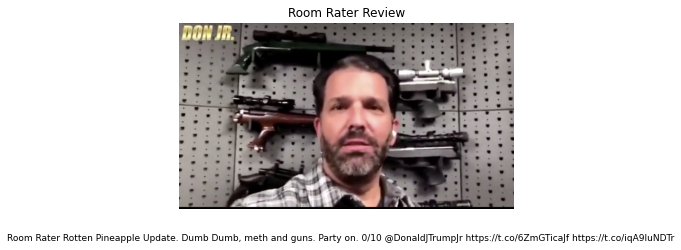

In [162]:
view_tweet(rated_clean, min_ex)

Looking at the 0/10 tweets, we can see RoomRater reserves 0 rating for people with poor decorum and not meerly poor decor.

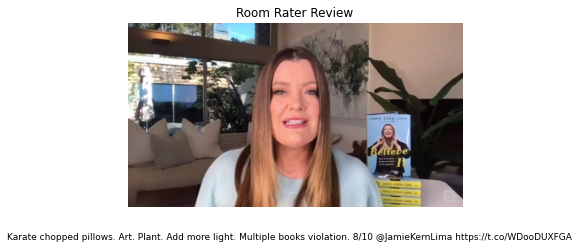

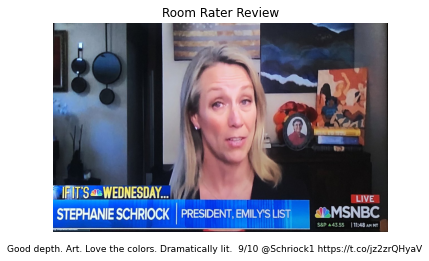

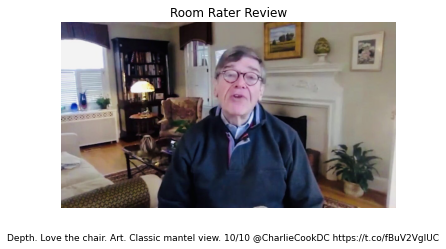

In [171]:
# Most other users get scores of 8 and above. Let's take a closer look at what distinguishes an 8, 9, and 10
view_tweet(rated_clean, q1_ex)
view_tweet(rated_clean, q2_ex)
view_tweet(rated_clean, max_ex)

In the above examples, all three have a variety of decor, but the 8/10 had a "multiple book violation", 
and the 10/10 was distinguished by having depth.

Through Natural Language Processing and Machine Learning, we can try to better understand the nuances bewteen these various ratings.

## Data Preprocessing

In [9]:
def tokenize(text):
    """Input text and return clean, normalized, tokenized, and lemmatized text."""
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    stop_words = stopwords.words("english")
    
    # Remove URLs
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, " ")
        
    lemmatizer = WordNetLemmatizer()
    
    # Normalize case and remove punctuation, extra spaces, and numbers (ex. ratings) from text
    text = re.sub(r"[^a-zA-Z]", " ", text.lower().strip())
    
    # Tokenize text
    tokens = word_tokenize(text)
    
    # Lemmatize and remove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens

### Visualizing the Text

Before proceeding to the models, let's use the tokenizer to visualize what keywords are most common in RoomRater tweets.

In [18]:
tweet_text = rated_clean['tweet_text'].tolist()
tokenized_text = []
for i in tweet_text:
    token_i = tokenize(i)
    tokenized_text.append(token_i)

In [20]:
full_text = [k for j in tokenized_text for k in j]

In [21]:
# https://www.datacamp.com/community/tutorials/text-analytics-beginners-nltk
fdist = FreqDist(full_text)

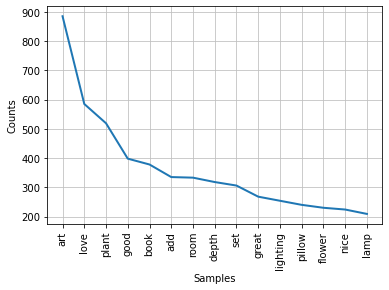

In [13]:
fdist.plot(15, cumulative=False)
plt.show()

We can tell RoomRater cares most about *art* in the background, followed by *plants, books*, and a sense of *depth*. After that, *lighting, pillows*, and *flowers* factor in.

Let's see how the top keywords change according to the rating.

In [14]:
def visualize_text(df, rating):
    """Input dataframe and tweet rating. Return sorted list of keywords."""
    select_ratings = rated_clean.query('rating == @rating')

    # Tokenize text
    tweet_text = select_ratings['tweet_text'].tolist()
    tokenized_text = []
    for i in tweet_text:
        token_i = tokenize(i)
        tokenized_text.append(token_i)    
    
    # Combine lists 
    full_text = [k for j in tokenized_text for k in j]
    fdist = FreqDist(full_text)
    
    return fdist

In [16]:
# Let's run the tokenization for each rating to see how the top vocabulary changes by rating.
words_10 = visualize_text(rated_clean, 10)
words_9 = visualize_text(rated_clean, 9)
words_8 = visualize_text(rated_clean, 8)
words_7 = visualize_text(rated_clean, 7)
words_6 = visualize_text(rated_clean, 6)
words_5 = visualize_text(rated_clean, 5)
words_4 = visualize_text(rated_clean, 4)
words_3 = visualize_text(rated_clean, 3)
words_2 = visualize_text(rated_clean, 2)
words_1 = visualize_text(rated_clean, 1)
words_0 = visualize_text(rated_clean, 0)

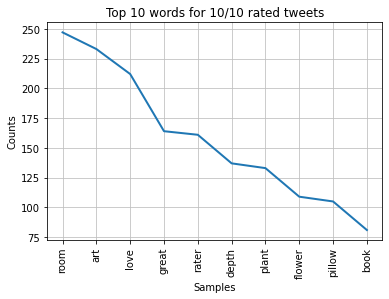

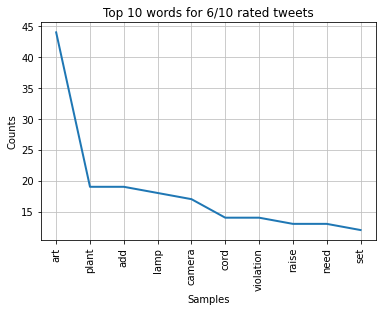

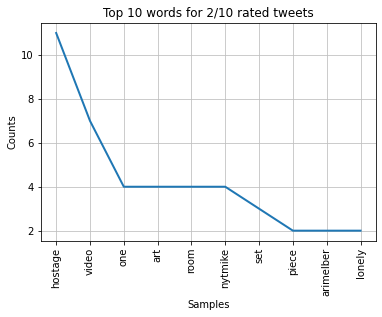

In [32]:
# Let's visualize keywords for high, mid, and low ratings
words_10.plot(10, cumulative=False, 
              title='Top 10 words for 10/10 rated tweets')

words_6.plot(10, cumulative=False, 
              title='Top 10 words for 6/10 rated tweets')

words_2.plot(10, cumulative=False, 
              title='Top 10 words for 2/10 rated tweets')

plt.show()

We can see *art* present at all levels, but mid-level ratings have keywords like *add*, suggesting their backgrounds may be a bit sparse, as well as *camera*, and *cord*, suggesting their camera setup could improve. Low ratings have more critical issues, such as the *hostage video* esthetic, which is a flat, plain white background with little to no decor.

Let's look at the top keywords for all the ratings, side by side.

In [34]:
most_common_10 = words_10.most_common(8)
top_words_10 = [i[0] for i in most_common_10]

most_common_9 = words_9.most_common(8)
top_words_9 = [i[0] for i in most_common_9]

most_common_8 = words_8.most_common(8)
top_words_8 = [i[0] for i in most_common_8]

most_common_7 = words_7.most_common(8)
top_words_7 = [i[0] for i in most_common_7]

most_common_6 = words_6.most_common(8)
top_words_6 = [i[0] for i in most_common_6]

most_common_5 = words_5.most_common(8)
top_words_5 = [i[0] for i in most_common_5]

most_common_4 = words_4.most_common(8)
top_words_4 = [i[0] for i in most_common_4]

most_common_3 = words_3.most_common(8)
top_words_3 = [i[0] for i in most_common_3]

most_common_2 = words_2.most_common(8)
top_words_2 = [i[0] for i in most_common_2]

most_common_1 = words_1.most_common(8)
top_words_1 = [i[0] for i in most_common_1]

print("""10/10    \t9/10    \t8/10    \t7/10    \t6/10""")
for a, b, c, d, e in zip(top_words_10, top_words_9, top_words_8, top_words_7, top_words_6):
    print(a.ljust(9, ' '), b.ljust(9, ' '), c.ljust(9, ' '), d.ljust(9, ' '), e.ljust(9, ' '), sep='\t')
print('\n')
print("""5/10    \t4/10    \t3/10    \t2/10    \t1/10""")
for f, g, h, i, j in zip(top_words_5, top_words_4, top_words_3, top_words_2, top_words_1):
    print(f.ljust(9, ' '), g.ljust(9, ' '), h.ljust(9, ' '), i.ljust(9, ' '), j.ljust(9, ' '), sep='\t')
    
#https://stackoverflow.com/questions/12142133/how-to-get-first-element-in-a-list-of-tuples
#https://stackoverflow.com/questions/48053979/print-2-lists-side-by-side
#https://thispointer.com/python-how-to-pad-strings-with-zero-space-or-some-other-character/

10/10    	9/10    	8/10    	7/10    	6/10
room     	art      	art      	art      	art      
art      	love     	good     	add      	plant    
love     	plant    	plant    	plant    	add      
great    	good     	add      	set      	lamp     
rater    	book     	book     	book     	camera   
depth    	add      	love     	good     	cord     
plant    	depth    	set      	camera   	violation
flower   	nice     	camera   	reframe  	raise    


5/10    	4/10    	3/10    	2/10    	1/10
camera   	art      	nytmike  	hostage  	room     
lighting 	camera   	room     	video    	oh       
art      	violation	hostage  	one      	dear     
plant    	cord     	video    	art      	point    
book     	lighting 	camera   	room     	liked    
overhead 	nice     	raise    	nytmike  	cat      
nice     	raise    	rater    	set      	better   
shelf    	book     	update   	piece    	cyallianceprez


**Takeaways:** 

- For 8's and 9's to move up, the word *add* first appears on the list, suggesting they just need to focus on adding a few more items to reach that 10. 
- The apearance of the word *camera* in ratings 3-8 suggest varing degrees of skill with camera angle distinguish these folks. - *Lamp* and *Lighting* make an appearance at levels 6 and below, where people may either have a glaring lamp in view, or poor lighting conditions.
- At rating 6 and below we also see the word *violation* and *cord* emmerge, suggesting folks could clean up their wires in range of view. These words move up the list as the ratings drop to 4. We also see *raise* in mid- to low ratings, likely referring to people looking down at the camera rather than having the camera straight ahead.
- 2's and 3's tend to be "hostage videos" - a blank white wall with no decore in sight

We can see examples of the above by looking at images and text by rating:

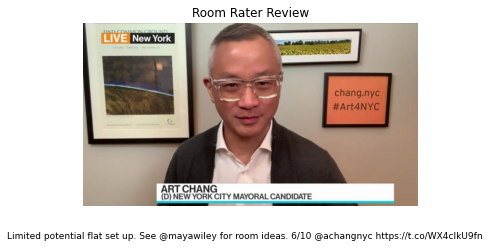

In [42]:
r6_ex = rated_clean.query('rating == 6').iloc[0][0]
view_tweet(rated_clean, r6_ex)

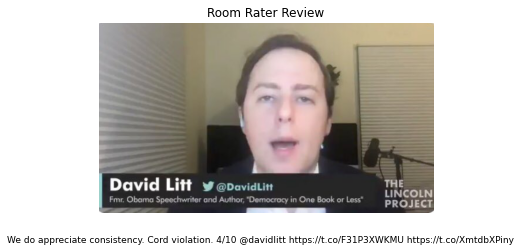

In [126]:
r4_ex = rating_2 = rated_clean.query('rating == 4').iloc[3][0]
view_tweet(rated_clean, r4_ex)

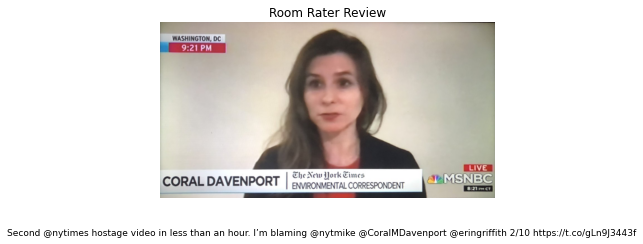

In [122]:
r2_ex = rating_2 = rated_clean.query('rating == 2').iloc[4][0]
view_tweet(rated_clean, r2_ex)

## NLP and Model: Implementation and Refinement

This section will run ML pipelines to classify the tweets into ratings based on the tweet text. The pipelines will first tokenize and transform the text for ingestion in the models. GridSearchCV will then be used to select the best parameters. 

After each model is run, it will be evaluated with metrics as well as a visualization comparing the actual versus the predicted ratings. 

Models compared:
- Random Forest Classifier (fits multipe decision tree classifiers on different sub-samples to minimize over-fitting)
- Balanced Random Forest Classifier (balances by employing under-sampling to the random forest classifier) 
- Gradient Boosting Classifier (runs multiple Decision Tree classifiers to minimize the loss function)
- Easy Ensemble Classifier (using the AdaBoost Classifier as a base estimator, employs random under-sampling on the bootstrap samples)
- Ordinal Logistic Regresstion (a classifier that takes into account that the order of the ratings are meaningful)

### Functions for Model Evaulation and Visualization

As the predicted variable is multi-class (with outputs ranging from 0-10), the outcome labels must be binarized in order to calculate the ROC AUC score.

In [162]:
def roc_auc_multiclass(y_test, y_pred, multi_class='ovo',average='macro'):
    """Input y_test and y_pred for multi-class model, return ROC AUC score."""
    labels = list(set(y_test))

    y_test_bin = label_binarize(y_test,
                              classes=labels)

    y_pred_bin = label_binarize(y_pred,
                               classes=labels)

    roc_auc_multi = roc_auc_score(y_test_bin, y_pred_bin,
                  multi_class=multi_class,
                 average=average)
    
    return round(roc_auc_multi,2)

#Ref: https://stackoverflow.com/questions/63303682/sklearn-multiclass-roc-auc-score

In [11]:
def create_results_df(clean_df, y_pred):
    """Input clean dataframe and y_pred, return dataframe with actual and predicted ratings"""
    pred_df = rated_clean.copy()
    pred_df['preds'] = pd.Series(y_pred)

    # Calculate difference between actual and predicted rating
    pred_df['diff'] = pred_df['rating']-pred_df['preds']
    pred_df.sort_values(by=['diff'], ascending=False).head()
    
    return pred_df

In [12]:
def view_heatmap(pred_df):
    """Input pred_df from create_results_df(), return heatmap comparing actual with predicted ratings"""
    sum_df = pd.DataFrame(pred_df[['rating','preds','tweet_id']].groupby(by=['rating', 'preds']).count()
                          .reset_index())

    sum_df = sum_df.rename(columns={'tweet_id':'count'})

    sum_pivot = sum_df.pivot('rating','preds','count')

    ax = sns.heatmap(sum_pivot, annot=True, cmap = 'YlGnBu', fmt='n')
    ax.invert_yaxis()
    plt.title('Actual v Predicted Rating: # Tweets')
    plt.show()

In [65]:
def print_scores(y_test, y_pred, pred_df):
    """Input y_test, y_pred, return model performance scores"""
    
    print('accuracy score: ', round(accuracy_score(y_test, y_pred),2))
    print('precision score: ', round(precision_score(y_test, y_pred, average='weighted'),2))
    print('recall score: ', round(recall_score(y_test, y_pred, average='weighted'),2))
    print('f1 score: ', round(f1_score(y_test, y_pred, average='weighted'),2))
    print('roc_auc_score: ', round(roc_auc_multiclass(y_test,
                                     y_pred),2))
    
    # Because our output is ordinal, 
    #   we can also look at the average distance between the predicted and actual rating. 
    #   We'll use the absolute value so that over and under predictions don't cancel out.
    print('avg diff, actual v pred: ', round(abs(pred_df['diff']).mean(),2))

### Random Forest Classifier

First let's compare the performance of the Random Forest Classifier and the Balanced Random Forest Classifier.

In [13]:
def build_rf_model():
    """Use Pipeline to transform text and build a Random Forest Classifier with parameters selected based on GridSearch"""
    pipeline = Pipeline([
            
            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
        ])),
        
        ('clf', RandomForestClassifier(random_state=random_state))
    ])
    
    # After multiple runs with GridSerachCV, store best parameters in final model
    best_parameters = {
        'clf__n_estimators': [100, 200],
        'clf__min_samples_leaf': [2, 4],
        'clf__class_weight': ['balanced', 'balanced_subsample']
    }
    
    cv = GridSearchCV(pipeline, param_grid = best_parameters, verbose=3)
    
    return cv

In [108]:
def apply_model(clean_df, model_fn):
    """Input clean dataframe and mode, return model, X_test, y_test, and y_pred"""
    X = clean_df['tweet_text']
    y = clean_df['rating']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    model = model_fn 

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    return model, X_test, y_test, y_pred

In [86]:
model_rf, X_test_rf, y_test_rf, y_pred_rf = apply_model(rated_clean, build_rf_model())

Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\laure\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


[CV 1/5] END clf__class_weight=balanced, clf__min_samples_leaf=2, clf__n_estimators=100; total time=   2.1s
[CV 2/5] END clf__class_weight=balanced, clf__min_samples_leaf=2, clf__n_estimators=100; total time=   2.0s
[CV 3/5] END clf__class_weight=balanced, clf__min_samples_leaf=2, clf__n_estimators=100; total time=   2.0s
[CV 4/5] END clf__class_weight=balanced, clf__min_samples_leaf=2, clf__n_estimators=100; total time=   2.0s
[CV 5/5] END clf__class_weight=balanced, clf__min_samples_leaf=2, clf__n_estimators=100; total time=   2.0s
[CV 1/5] END clf__class_weight=balanced, clf__min_samples_leaf=2, clf__n_estimators=200; total time=   2.5s
[CV 2/5] END clf__class_weight=balanced, clf__min_samples_leaf=2, clf__n_estimators=200; total time=   2.5s
[CV 3/5] END clf__class_weight=balanced, clf__min_samples_leaf=2, clf__n_estimators=200; total time=   2.5s
[CV 4/5] END clf__class_weight=balanced, clf__min_samples_leaf=2, clf__n_estimators=200; total time=   2.5s
[CV 5/5] END clf__class_weig

In [57]:
model_rf.best_params_

{'clf__class_weight': 'balanced_subsample',
 'clf__min_samples_leaf': 2,
 'clf__n_estimators': 100}

In [58]:
pred_df_rf = create_results_df(rated_clean, y_pred_rf)
pred_df_rf.head(3)

,tweet_id,tweet_text,image_url,favorites,rating,preds,diff
0,1364758339079479296,Depth. Love the chair. Art. Classic mantel vie...,http://pbs.twimg.com/media/EvCYedsVkAAhmnb.jpg,189,10,9.0,1.0
1,1364755341175480323,Karate chopped pillows. Art. Plant. Add more l...,http://pbs.twimg.com/media/EvCVv9bUYAE-SQx.jpg,111,8,10.0,-2.0
2,1364730053234290690,Room Rater Fluffy Room. A pineapple can be so ...,http://pbs.twimg.com/media/EvB-v_8VoAcqEHy.jpg,949,10,0.0,10.0


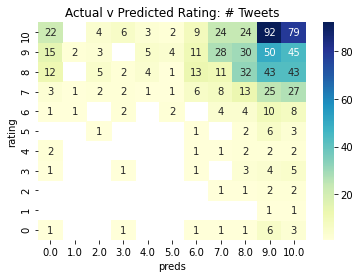

In [31]:
view_heatmap(pred_df_rf)

In [67]:
print_scores(y_test_rf, y_pred_rf, pred_df_rf)

accuracy score:  0.45
precision score:  0.5
recall score:  0.45
f1 score:  0.46
roc_auc_score:  0.65
avg diff, actual v pred:  2.36


### Balanced Random Forest Classifier

This model balances by under-sampling each bootstrap sample.

In [68]:
def build_brf_model():
    """Use Pipeline to build a Balanced Random Forest Classifier with parameters selected based on GridSearch"""
    pipeline = Pipeline([
            
            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
        ])),
        
        ('clf', BalancedRandomForestClassifier(random_state=random_state))
    ])
    
    best_parameters = {
        'clf__n_estimators': [100],
        'clf__min_samples_leaf': [2, 4],
        'clf__class_weight': ['balanced', 'balanced_subsample']
    }
    
    cv = GridSearchCV(pipeline, param_grid = best_parameters, verbose=3)
    
    return cv

In [69]:
model_brf, X_test_brf, y_test_brf, y_pred_brf = apply_model(rated_clean, build_brf_model())

Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\laure\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


[CV 1/5] END clf__class_weight=balanced, clf__min_samples_leaf=2, clf__n_estimators=100; total time=   2.1s
[CV 2/5] END clf__class_weight=balanced, clf__min_samples_leaf=2, clf__n_estimators=100; total time=   2.0s
[CV 3/5] END clf__class_weight=balanced, clf__min_samples_leaf=2, clf__n_estimators=100; total time=   2.2s
[CV 4/5] END clf__class_weight=balanced, clf__min_samples_leaf=2, clf__n_estimators=100; total time=   2.1s
[CV 5/5] END clf__class_weight=balanced, clf__min_samples_leaf=2, clf__n_estimators=100; total time=   2.1s
[CV 1/5] END clf__class_weight=balanced, clf__min_samples_leaf=4, clf__n_estimators=100; total time=   2.1s
[CV 2/5] END clf__class_weight=balanced, clf__min_samples_leaf=4, clf__n_estimators=100; total time=   2.2s
[CV 3/5] END clf__class_weight=balanced, clf__min_samples_leaf=4, clf__n_estimators=100; total time=   2.2s
[CV 4/5] END clf__class_weight=balanced, clf__min_samples_leaf=4, clf__n_estimators=100; total time=   2.1s
[CV 5/5] END clf__class_weig

In [70]:
model_brf.best_params_

{'clf__class_weight': 'balanced_subsample',
 'clf__min_samples_leaf': 2,
 'clf__n_estimators': 100}

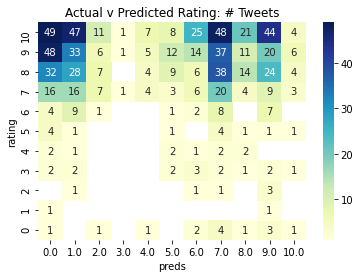

In [71]:
pred_df_brf = create_results_df(rated_clean, y_pred_brf)
view_heatmap(pred_df_brf)

The heatmap shows some rather noticeable misclassifications, where tweets rated 10 were predicted to have a rating of 0. 

In [73]:
print_scores(y_test_brf, y_pred_brf, pred_df_brf)

accuracy score:  0.1
precision score:  0.33
recall score:  0.1
f1 score:  0.11
roc_auc_score:  0.55
avg diff, actual v pred:  4.54


In [42]:
pred_df_brf[['rating','preds']].describe()

,rating,preds
count,2241.000000,805.000000
mean,8.348059,6.534161
std,2.051406,3.274033
min,0.000000,0.000000
25%,8.000000,4.000000
50%,9.000000,8.000000
75%,10.000000,9.000000
max,10.000000,10.000000


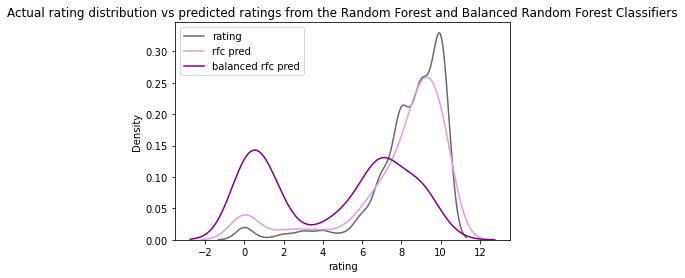

In [104]:
ax1 = sns.kdeplot(pred_df_brf.rating, 
                  color='dimgray',
                  legend=True,
                  label='rating')

ax2 = sns.kdeplot(pred_df_rf.preds, 
                  color='plum',
                  legend=True,
                  label='rfc pred')

ax3 = sns.kdeplot(pred_df_brf.preds, 
                  color='purple',
                  legend=True,
                  label='balanced rfc pred')

plt.legend()
plt.title('Actual rating distribution vs predicted ratings from the Random Forest and Balanced Random Forest Classifiers')
plt.show()

*Analysis*

Descriptive statistics show that the predictions on average were about two ratings lower than the actual ratings. The standard deviation was also 1.5 ratings wider. 

The Balanced Random Forest Classifier performed more poorly on all evaluation metrics in comparison with the Random Forest Classifier. Although this would suggest that of the two, the Random Forest Classifier would be the better model, we might want to consider whether the test data set reflects the real world reality. We know that RoomRater provides a lot of 10/10 ratings. Does this match what the reality or is RoomRater introducing bias into the photos they choose to post? From personal experience, the average background I see among my colleagues (including my own!) is rather plain and 1-dimentional, and would likely not be a 10/10.

The distriution plot above compares the actual ratings with the predicted ratings from both the Random Forest Classifier and the Balanced Random Forest Classifier. We can see the balanced classifier yields a wider distribution of predictions. If we were to determine that the real world was more similar to the distribution that the Balanced Random Forest Classifier is generating, then perhaps the balanced model would actually be more suited for wider application.

### Gradient Boosting Classifier

This classifier combines numerous weak Decision Tree classifiers, running models sequentially to optimizing the loss function.

Because the Gradient Boosting Classifier can be sensitive to parameter tuning, this model was run a couple times with other parameters. The best of those will be used, and we'll use this run to test various max_depth values.

`model.best_params_
{'clf__learning_rate': 0.05,
 'clf__min_samples_split': 4,
 'clf__n_estimators': 200}`
 
Performance from the above parameters:  
 `accuracy score:  0.47
precision score:  0.42
recall score:  0.47
f1 score:  0.43
roc_auc_score:  0.58
avg diff, actual v pred:  1.71`

In [107]:
def build_gb_model():
    """Use Pipeline to build a Gradient Boosting Classifier with parameters selected based on GridSearch"""
    pipeline = Pipeline([
            
            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
        ])),
        
        ('clf', GradientBoostingClassifier(random_state=random_state))
    ])
    
    # After multiple runs with GridSerachCV, store best parameters in final model
    best_parameters = {
        'clf__n_estimators': [200],
        'clf__min_samples_split': [4], #GridSearchCV chose 4 over 2
        'clf__learning_rate': [.05], #GridSearchCV chose 0.05 over 0.1
        'clf__max_depth':[2, 3, 4]
        
    }
    
    cv = GridSearchCV(pipeline, param_grid = best_parameters, verbose=3)
    
    return cv

In [109]:
model_gb, X_test_gb, y_test_gb, y_pred_gb = apply_model(rated_clean, build_gb_model())

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END clf__learning_rate=0.05, clf__max_depth=2, clf__min_samples_split=4, clf__n_estimators=200; total time=  14.3s
[CV 2/5] END clf__learning_rate=0.05, clf__max_depth=2, clf__min_samples_split=4, clf__n_estimators=200; total time=  14.2s
[CV 3/5] END clf__learning_rate=0.05, clf__max_depth=2, clf__min_samples_split=4, clf__n_estimators=200; total time=  14.2s
[CV 4/5] END clf__learning_rate=0.05, clf__max_depth=2, clf__min_samples_split=4, clf__n_estimators=200; total time=  14.2s
[CV 5/5] END clf__learning_rate=0.05, clf__max_depth=2, clf__min_samples_split=4, clf__n_estimators=200; total time=  14.4s
[CV 1/5] END clf__learning_rate=0.05, clf__max_depth=3, clf__min_samples_split=4, clf__n_estimators=200; total time=  19.0s
[CV 2/5] END clf__learning_rate=0.05, clf__max_depth=3, clf__min_samples_split=4, clf__n_estimators=200; total time=  18.9s
[CV 3/5] END clf__learning_rate=0.05, clf__max_depth=3, clf__min_samples

In [111]:
model_gb.best_params_

{'clf__learning_rate': 0.05,
 'clf__max_depth': 4,
 'clf__min_samples_split': 4,
 'clf__n_estimators': 200}

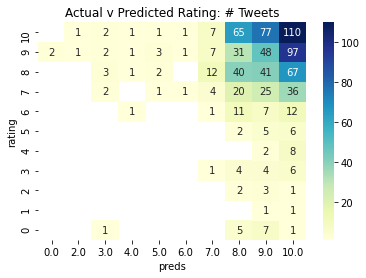

In [114]:
pred_df_gb = create_results_df(rated_clean, y_pred_gb)
view_heatmap(pred_df_gb)

In [115]:
print_scores(y_test_gb, y_pred_gb, pred_df_gb)

accuracy score:  0.51
precision score:  0.44
recall score:  0.51
f1 score:  0.47
roc_auc_score:  0.57
avg diff, actual v pred:  1.66


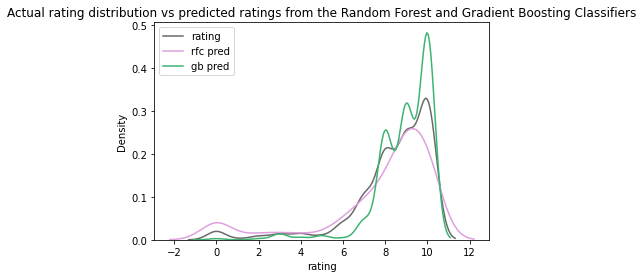

In [145]:
ax1 = sns.kdeplot(pred_df_rf.rating, 
                  color='dimgray',
                  legend=True,
                  label='rating')

ax2 = sns.kdeplot(pred_df_rf.preds, 
                  color='plum',
                  legend=True,
                  label='rfc pred')

ax3 = sns.kdeplot(pred_df_gb.preds, 
                  color='mediumseagreen',
                  legend=True,
                  label='gb pred')

plt.legend()
plt.title('Actual rating distribution vs predicted ratings from the Random Forest and Gradient Boosting Classifiers')
plt.show()

The Gradient Boosting Classifier performed better on accuracy and recall, while the Random Forest Classifier performed better on precision and ROC AUC.

### Balanced AdaBoost Classifier

The EasyEnsembleClassifier employs different bootstrap samples to the base estimator, the AdaBoost Classifier, that are balanced via random under-sampling.

https://imbalanced-learn.org/dev/references/generated/imblearn.ensemble.EasyEnsembleClassifier.html

In [147]:
def build_eec_model():
    """Use Pipeline to transform text and build Easy Ensemble Classifier"""
    pipeline = Pipeline([
            
            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
        ])),
        
        ('clf', EasyEnsembleClassifier(random_state=random_state))
    ])
    

    best_parameters = {        
        'clf__n_estimators': [200]
    }
    
    cv = GridSearchCV(pipeline, param_grid = best_parameters)
    
    return cv

In [152]:
model_eec, X_test_eec, y_test_eec, y_pred_eec = apply_model(rated_clean, build_eec_model())

C:\Users\laure\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


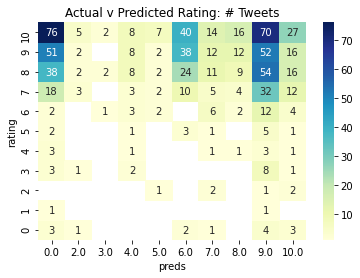

In [134]:
pred_df_eec = create_results_df(rated_clean, y_pred_eec)
view_heatmap(pred_df_eec)

In [135]:
print_scores(y_test_eec, y_pred_eec, pred_df_eec)

accuracy score:  0.22
precision score:  0.46
recall score:  0.22
f1 score:  0.25
roc_auc_score:  0.59
avg diff, actual v pred:  3.76


C:\Users\laure\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


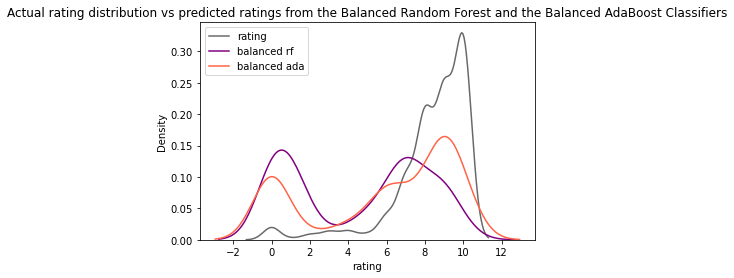

In [154]:
ax1 = sns.kdeplot(pred_df_rf.rating, 
                  color='dimgray',
                  legend=True,
                  label='rating')

ax3 = sns.kdeplot(pred_df_brf.preds, 
                  color='purple',
                  legend=True,
                  label='balanced rf')

ax3 = sns.kdeplot(pred_df_eec.preds, 
                  color='tomato',
                  legend=True,
                  label='balanced ada')

plt.legend()
plt.title('Actual rating distribution vs predicted ratings from the Balanced Random Forest and the Balanced AdaBoost Classifiers')
plt.show()

Like the Balanced Random Forest Classifier, the Balanced AdaBoost Classifier also flattens the distribution. The Balanced AdaBoost performs better than the Balanced Random Forest. We can see above that the Balanced Random Forest led to a more extreme re-balancing, with peaks around ratings of 0/10 and 7/10, instead of 10/10 like the actual values. The Balanced AdaBoost peaks at 9/10, a more close approximation of the actual values.

## Ordinal Logistic Regression

Because our predictor is ordinal, let's see if an ordinal model can improve the performance.

In [136]:
from mord import LogisticIT
#https://pythonhosted.org/mord/

def build_lit_model():
    """Use Pipeline to build Ordinal Logistic Regression with parameters selected based on GridSearch"""
    pipeline = Pipeline([
            
            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
        ])),
        
        ('lit', LogisticIT())
    ])
    
    best_parameters = {
        'lit__alpha': [0.5, 0.75, 1]
    }
    
    cv = GridSearchCV(pipeline, param_grid = best_parameters, verbose=3)
    
    return cv

In [137]:
model_lit, X_test_lit, y_test_lit, y_pred_lit = apply_model(rated_clean, build_lit_model())

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .................................lit__alpha=0.5; total time=   2.3s
[CV 2/5] END .................................lit__alpha=0.5; total time=   2.2s
[CV 3/5] END .................................lit__alpha=0.5; total time=   2.2s
[CV 4/5] END .................................lit__alpha=0.5; total time=   2.3s
[CV 5/5] END .................................lit__alpha=0.5; total time=   2.2s
[CV 1/5] END ................................lit__alpha=0.75; total time=   2.0s
[CV 2/5] END ................................lit__alpha=0.75; total time=   2.2s
[CV 3/5] END ................................lit__alpha=0.75; total time=   2.1s
[CV 4/5] END ................................lit__alpha=0.75; total time=   2.2s
[CV 5/5] END ................................lit__alpha=0.75; total time=   2.2s
[CV 1/5] END ...................................lit__alpha=1; total time=   2.1s
[CV 2/5] END ...................................l

In [140]:
model_lit.best_params_

{'lit__alpha': 0.75}

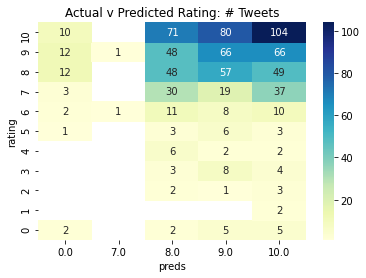

In [141]:
pred_df_lit = create_results_df(rated_clean, y_pred_lit)
view_heatmap(pred_df_lit)

In [143]:
print_scores(y_test_lit, y_pred_lit, pred_df_lit)

accuracy score:  0.5
precision score:  0.49
recall score:  0.5
f1 score:  0.47
roc_auc_score:  0.55
avg diff, actual v pred:  1.81


C:\Users\laure\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


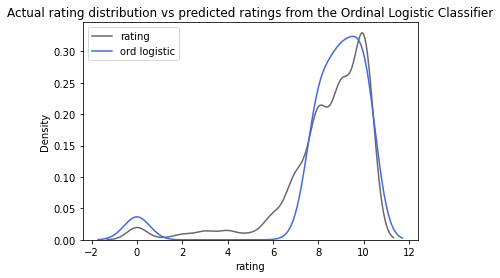

In [153]:
ax1 = sns.kdeplot(pred_df_rf.rating, 
                  color='dimgray',
                  legend=True,
                  label='rating')

ax3 = sns.kdeplot(pred_df_lit.preds, 
                  color='royalblue',
                  legend=True,
                  label='ord logistic')

plt.legend()
plt.title('Actual rating distribution vs predicted ratings from the Ordinal Logistic Classifier')
plt.show()

In [175]:
print("Summary of ROC AUC scores for each model  ")
print("""Random Forest    \tBalanced RF      \tGradient Boosting    \tBalanced AdaBoost    \tOrdinal Logistic""")

rf_scores = str(roc_auc_multiclass(y_test_rf, y_pred_rf))
brf_scores=str(roc_auc_multiclass(y_test_brf, y_pred_brf))
gb_scores=str(roc_auc_multiclass(y_test_gb, y_pred_gb))
ada_scores =str(roc_auc_multiclass(y_test_eec, y_pred_eec))
lit_scores = str(roc_auc_multiclass(y_test_lit, y_pred_lit))

print(rf_scores, brf_scores, gb_scores, ada_scores, lit_scores, sep='\t\t\t')

Summary of ROC AUC scores for each model  
Random Forest    	Balanced RF      	Gradient Boosting    	Balanced AdaBoost    	Ordinal Logistic
0.65			0.55			0.57			0.59			0.55


### Model Selection and Justification 

We looked at both non-sequential and sequential classifiers, both without and with balancing to address imbalanced data. We also looked at an ordinal classifier. 

The Random Forest Classifier was the only classifier that had an ROC AUC score above .6. With .5 signifying performance equivalent to random assignment, none of these models performed great.

If the real world population is similar to the sample that RoomRater has collected, with many excellent, 10/10-worthy backgrounds, the Random Forest Classifier would show the most potential. However, if people's web backgrounds in the real world are more mediocre, the Balanced AdaBoost may better account for that. 

Although we're working with an ordinal predictor, the Ordinal Logistic Regression on it's own did not perform better than the nominal classification models. However, it could be useful to develop a Random Forest Classifier that treats the predictor variable as ordinal. Adding in some balancing for minority classes, perhaps not as extreme as the Balanced AdaBoost, could further optimize the results.

## Conclusion

### Reflection

We were able to uncover patterns in what RoomRater thinks makes a great web conference background. Through Natural Language Processing, we were able to identify the key elements that make a good background: art, plants, and books. We also learned that merely having these elements in the background is does not a great background make. For top ratings, one must also create a sense of depth, and pay attention to framining and lighting.

The machine learning models did not perform as well. In addition to having a data comprised primarily of 10/10 ratings, the models did not take into account the sentiment of the tweet text. The presence of the word "art" in a tweet isn't enough to know whether the person is has art in their background, or is using it effectively. RoomRater could either be mentioning art as a suggestion for improvement or applauding the person's art gallery.

It's also hard to judge how well the models may perform in the real world, since the sample data was pre-selected by RoomRater. It's possible that the heavy skew toward 10/10 backgrounds is due to RoomRater selecting photos they like, and that the real world would have more of a normal distribution in background quality. 

### Recommendations for Improvement

**Sentiment analysis**

Adding sentiment analysis would likely improve the model. We see common words like "depth", "lighting", "reframe", but would gain more value if we could distinguish when these words are used positively or negatively. 

**Parts of speech/verb form analysis**

Identifying verb type, to see whether the command form is used, would also help us identify if RoomRater is either applauding the person for effective use or if they're making a recommendation. For example, the use of the gerund in "good reframing" is positive, whereas the use of the command form in "reframe" is a suggestion for improvement.

**Deep learning and image classification**

Another data source that could enhance the model is the actual photo. A neural netowrk could be developed to identify visual similarities in what makes a 10/10 background. Like sentiment analysis, this model could help assess the quality of the lighting, placement of the decore, and position of the camera.

One could take this project further and create an app that allows users to upload a photo of their web background, and through image analysis, recommendations would be made to add plants, artwork, books, or adjust lighting and framing.